# 머신러닝 모델 여정 실습 1. HR Data Classification

### 데이터 분석 목적
    - 직원 Profile 데이터를 활용해 이 직원이 추후 퇴사할 지 여부를 판단한다.
    - 이를 판단해 업무 공백이 없어 업무 효율을 높이고자 한다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# library for feature engineering and EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from IPython.display import Image
from datetime import datetime

# library for statistic
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import kruskal

from statsmodels.stats.outliers_influence import variance_inflation_factor

# library for sampling
from imblearn.combine import SMOTEENN

# library for machine learning
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from xgboost import plot_importance

## 1. Data Processing 1

### 1-1 Data Load

In [2]:
!pwd
path_lecture = "./drive/MyDrive/MLOps_Signature/Lecture_Practice/CH02/clip20_practice_HR/"
random_state = 1234

/content


In [5]:
df = pd.read_csv(path_lecture + "data/HR-Employee-Attrition.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [6]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

### 1-2 Duplicated Data 확인

In [7]:
print("중복된 항목 수 :", len(df[df.duplicated()]))

# 1. 머신러닝 데이터를 만드는, 데이터 준비 과정에서 문제가 없었는지.
# 2. 수집 시스템 자체에 문제가 없는지도.


중복된 항목 수 : 0


## 2. Data EDA

### 2-1 Data Type and Summary

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [9]:
# categorical and numeric columns
for column_name in list(df.columns):
    print(column_name, df[column_name].dtype, df[column_name].unique())

Age int64 [41 49 37 33 27 32 59 30 38 36 35 29 31 34 28 22 53 24 21 42 44 46 39 43
 50 26 48 55 45 56 23 51 40 54 58 20 25 19 57 52 47 18 60]
Attrition object ['Yes' 'No']
BusinessTravel object ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
DailyRate int64 [1102  279 1373 1392  591 1005 1324 1358  216 1299  809  153  670 1346
  103 1389  334 1123 1219  371  673 1218  419  391  699 1282 1125  691
  477  705  924 1459  125  895  813 1273  869  890  852 1141  464 1240
 1357  994  721 1360 1065  408 1211 1229  626 1434 1488 1097 1443  515
  853 1142  655 1115  427  653  989 1435 1223  836 1195 1339  664  318
 1225 1328 1082  548  132  746  776  193  397  945 1214  111  573 1153
 1400  541  432  288  669  530  632 1334  638 1093 1217 1353  120  682
  489  807  827  871  665 1040 1420  240 1280  534 1456  658  142 1127
 1031 1189 1354 1467  922  394 1312  750  441  684  249  841  147  528
  594  470  957  542  802 1355 1150 1329  959 1033 1316  364  438  689
  201 1427  857  933 1181 139

In [8]:
# categorical -> object
# numeric -> int64

list_casting_as_object = ["Education","EmployeeNumber","EnvironmentSatisfaction","JobInvolvement","JobLevel","JobSatisfaction","PerformanceRating","RelationshipSatisfaction","StockOptionLevel","WorkLifeBalance"]
for column_name in list_casting_as_object:
  df[column_name] = df[column_name].astype("object")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   object
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   object
 10  EnvironmentSatisfaction   1470 non-null   object
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   object
 14  JobLevel                

In [10]:
list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['int64']).columns)
target_column = "Attrition"
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

35
19
16


#### Summary of Data Set
##### - Number of Variables : 35
    categorical variables : 19 (target 포함)
    numeric variables : 16
##### - Number of observations : 1470
##### - Missing Cells : 0 columns
##### - Duplicated Rows : 0

### 2-2 Dependent(종속) Data Explore

<Axes: xlabel='Attrition', ylabel='count'>

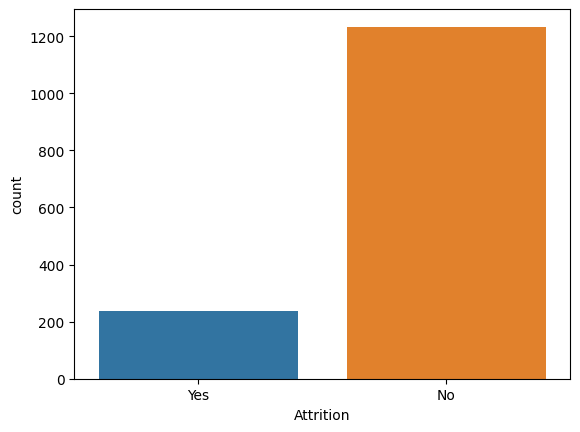

In [11]:
sns.countplot(x=target_column, data=df)

#### Imbalance data set?
  - 두 개 target class 비중 차이가 있다. 독립 변수가 categorical 이 포함된 경우는 one-hot encoding을 진행한 뒤에 sampling 을 해야 한다.
  - "Yes" Attrition을 갖는 데이터들이 유의미한 데이터 분포와 특성을 갖는다면, 추가적인 sampling 없이 모델 학습이 잘 될 수 있다.
  - ML 학습시 cost-sensitive (class weight 등)을 활용할 수 있다.

##### 1. 데이터 기반 접근 방법
    - Sampling (over sampling 혹은 under sampling)
    (이번 실습에서는 combine sampling 중에서 SMOTEENN 활용)
    https://imbalanced-learn.org/stable/references/combine.html
##### 2. ML 알고리즘 기반 접근 방법
    - ML 알고리즘 활용 -> ML 학습 시에 class weight를 활용하여 cost-sensitive learning
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### 2-3 Independent(독립) Data Explore

#### 1) Categorical Data Analysis

In [12]:
# 분석전 target column을 categorical list에서 제외
list_categorical_columns.remove(target_column)

##### 불필요한 컬럼 제거

In [13]:
df[list_categorical_columns].nunique().sort_values()

Over18                         1
PerformanceRating              2
OverTime                       2
Gender                         2
BusinessTravel                 3
Department                     3
MaritalStatus                  3
RelationshipSatisfaction       4
JobSatisfaction                4
WorkLifeBalance                4
StockOptionLevel               4
JobInvolvement                 4
EnvironmentSatisfaction        4
Education                      5
JobLevel                       5
EducationField                 6
JobRole                        9
EmployeeNumber              1470
dtype: int64

In [14]:
# 불필요한 컬럼을 제거
# Over18은 1개 값만 갖으므로 제거
# EmployeeNumber는 고유한 id 값으로 제거
df = df.drop(["Over18", "EmployeeNumber"], axis=1).copy()
list_categorical_columns.remove("Over18")
list_categorical_columns.remove("EmployeeNumber")
print(list_categorical_columns)

['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']


In [15]:
len(list_categorical_columns)

16

##### Column별 분포 확인

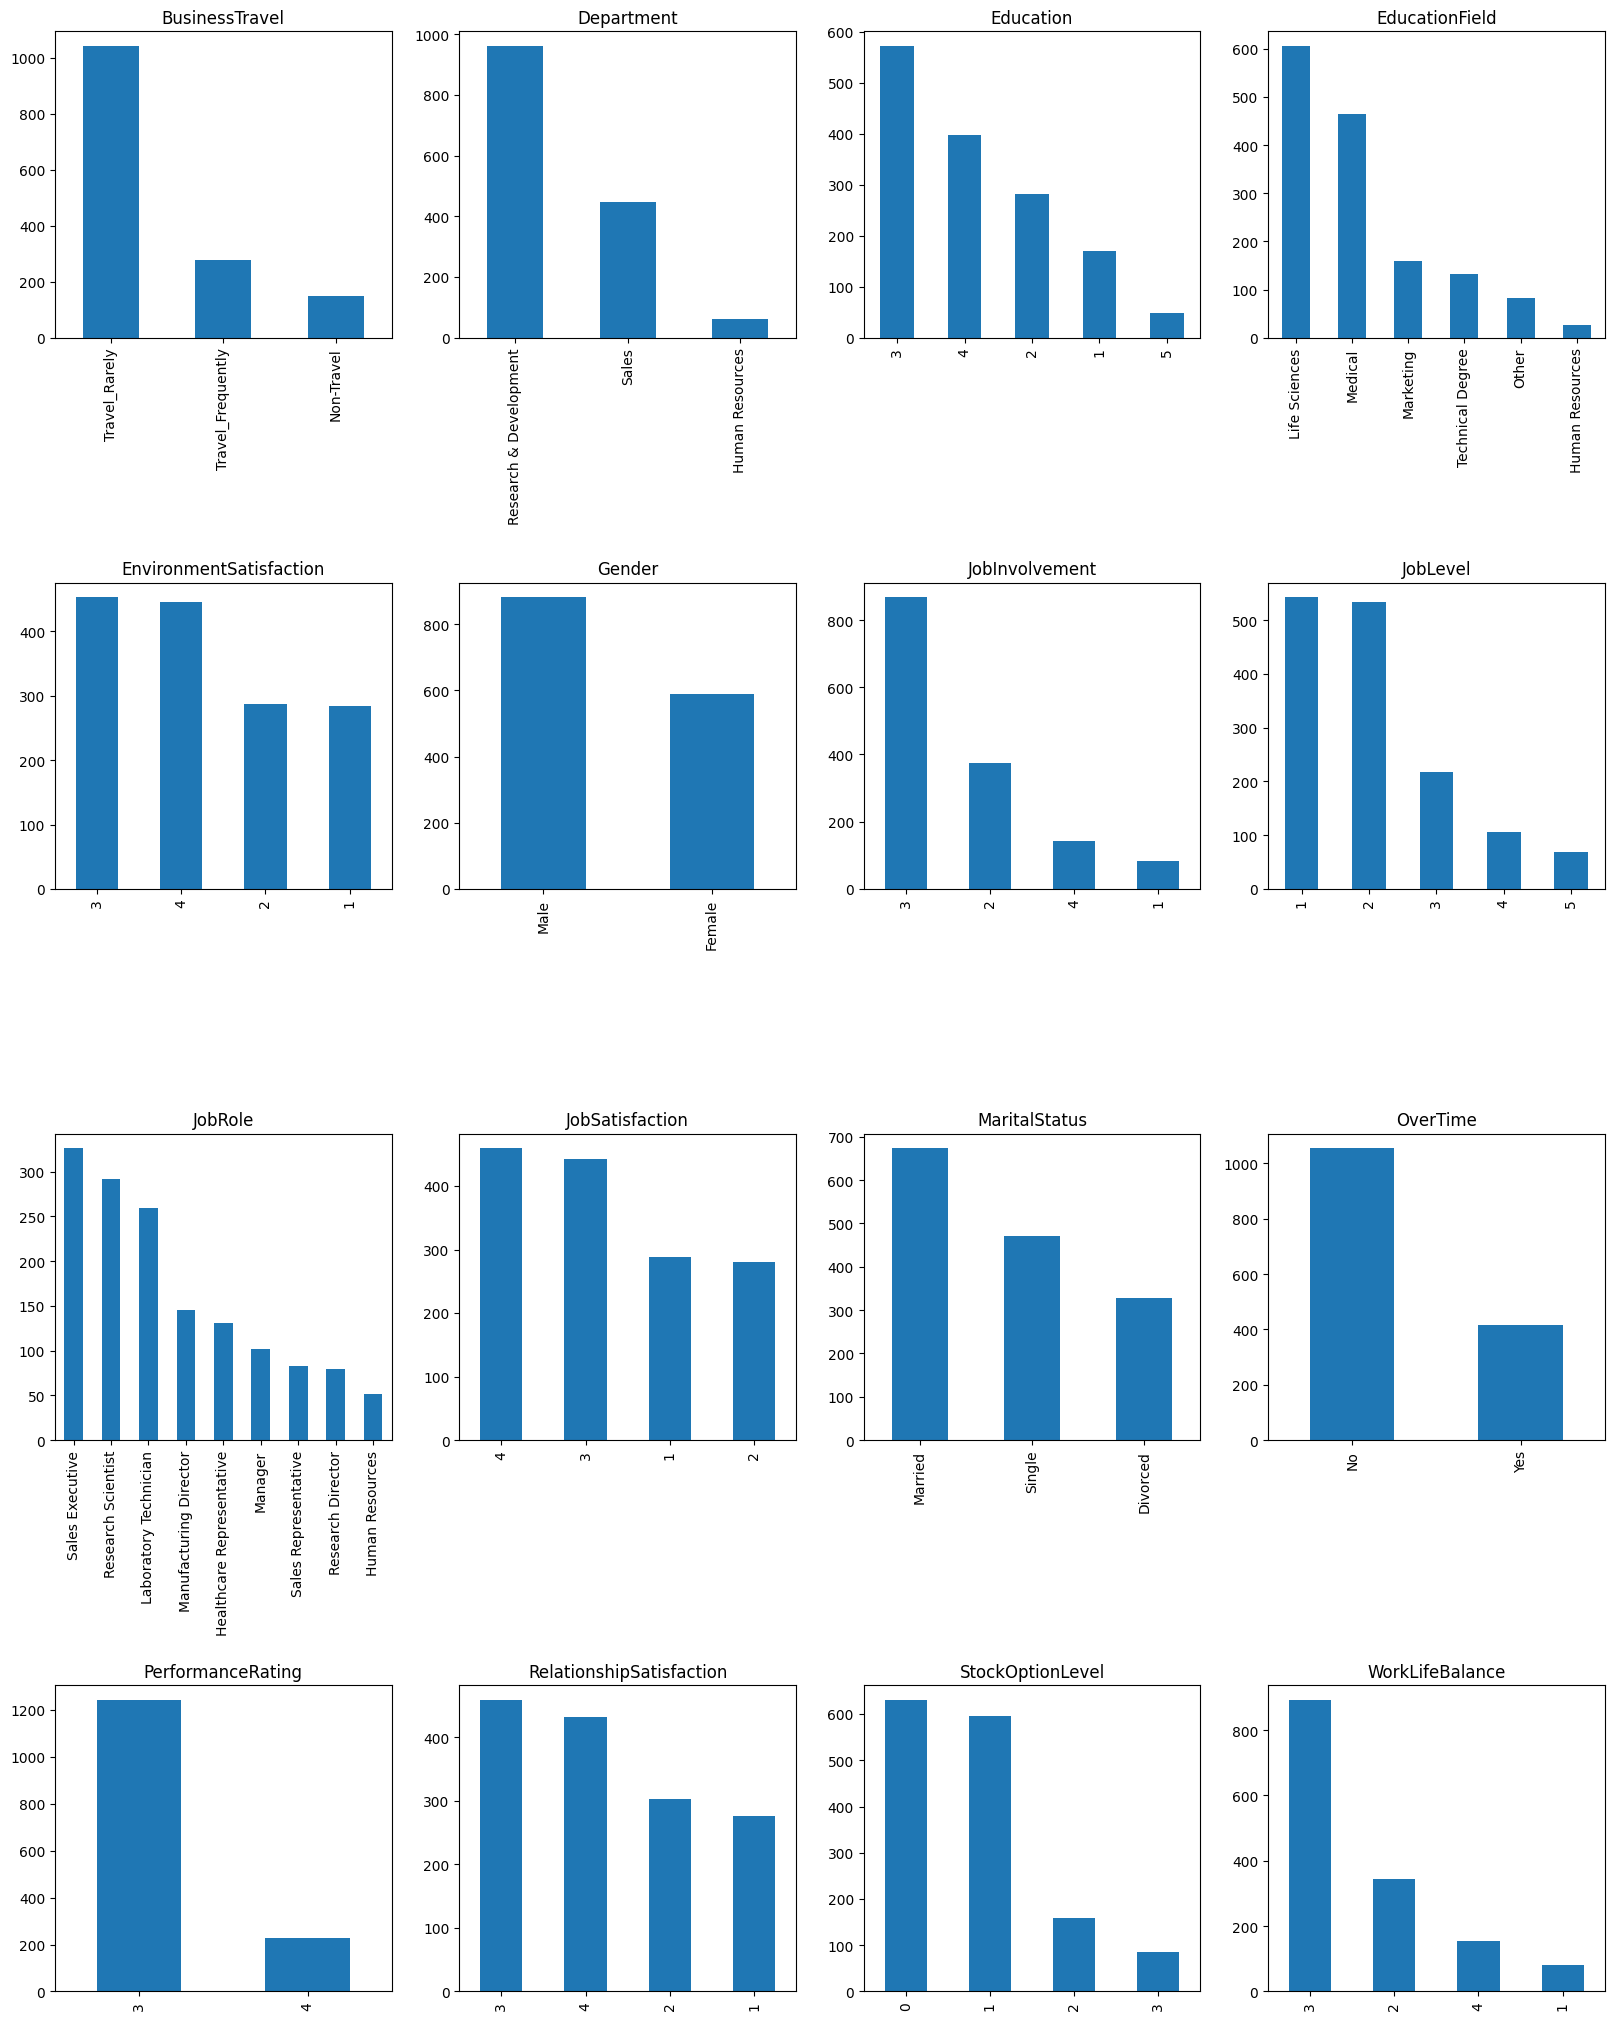

In [18]:
# cateogircla column 별 분포 확인
plt.figure(figsize=(20,20))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.8, wspace=0.2)
for column_name in list_categorical_columns:
    plt.subplot(4,4,x)
    x = x+1
    df[column_name].value_counts().plot(kind='bar')
    plt.title(column_name)
plt.show()

##### Target column과 categorical column 관계 분포 확인

<Figure size 3000x3000 with 0 Axes>

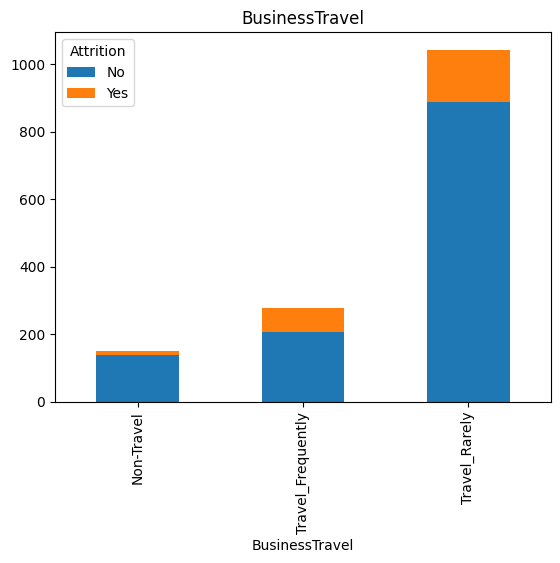

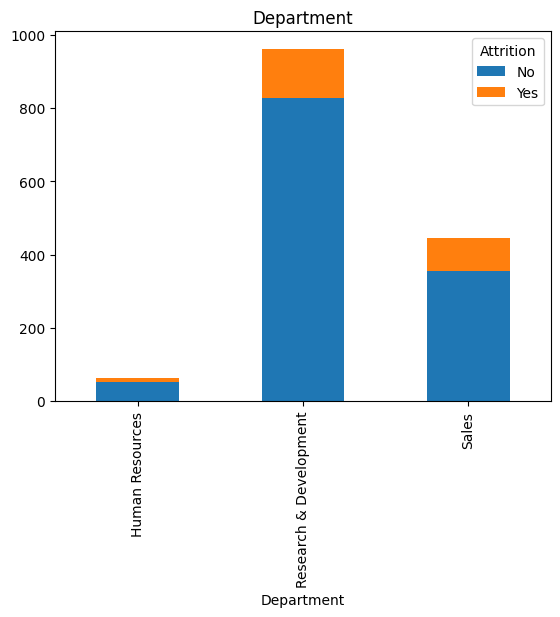

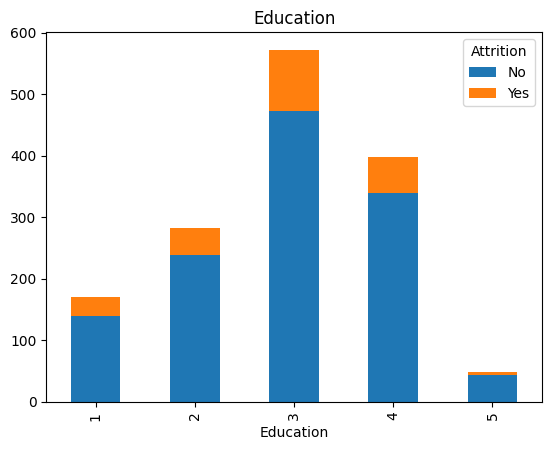

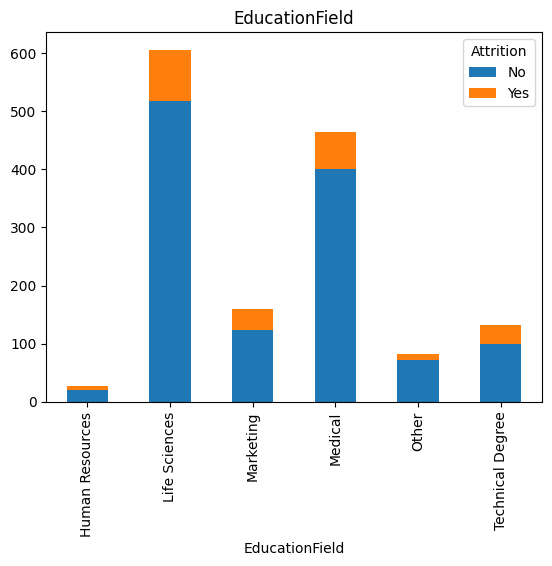

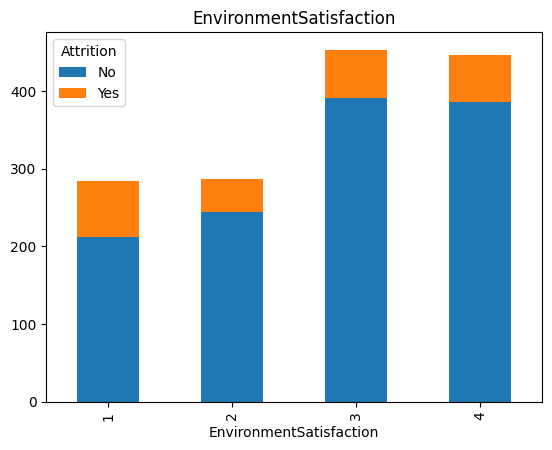

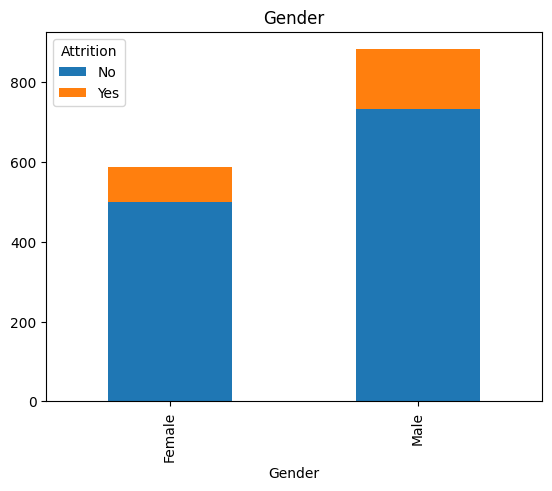

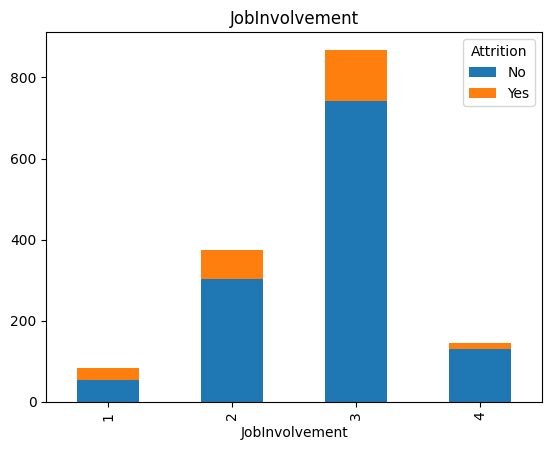

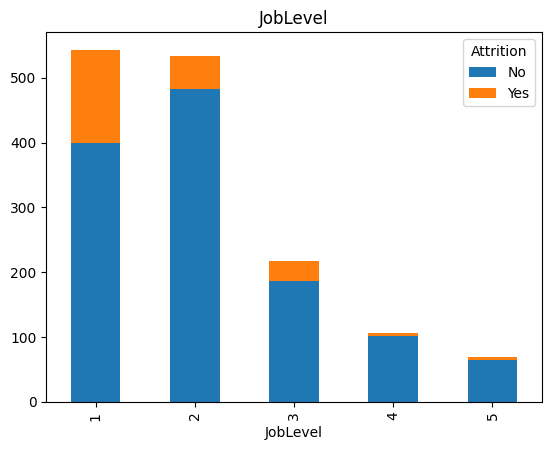

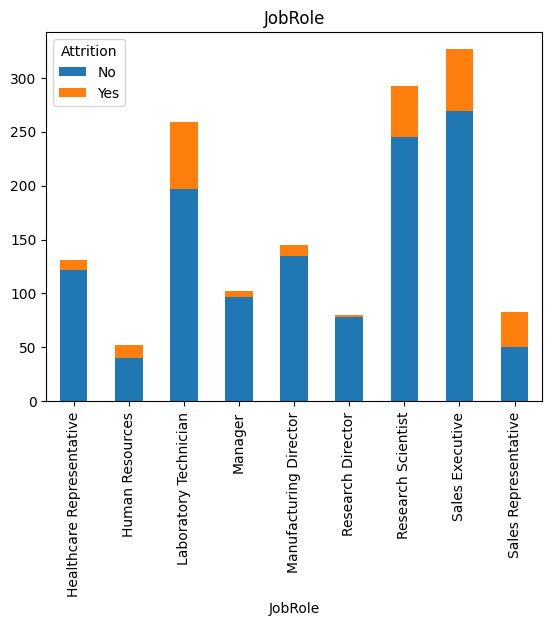

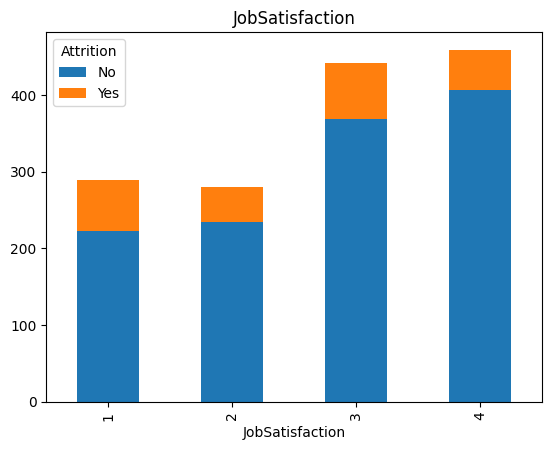

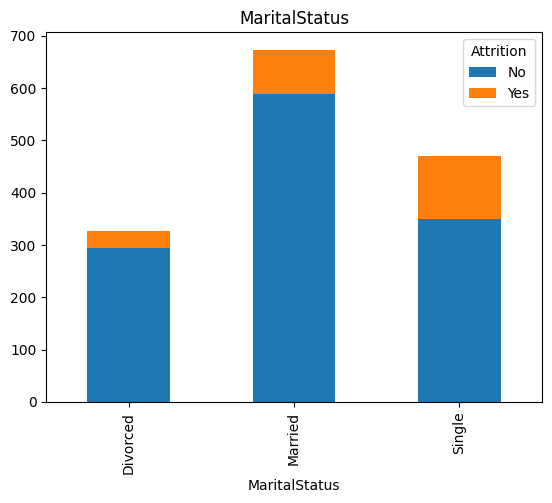

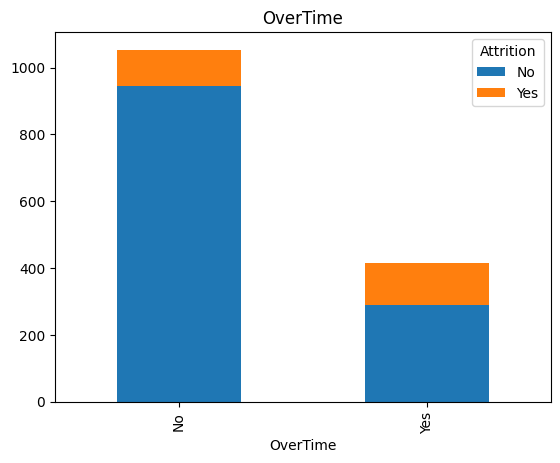

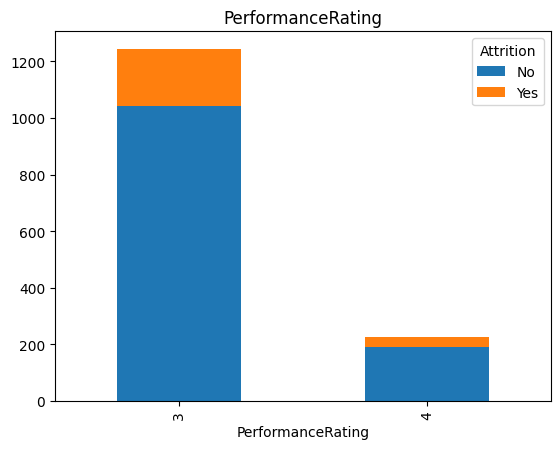

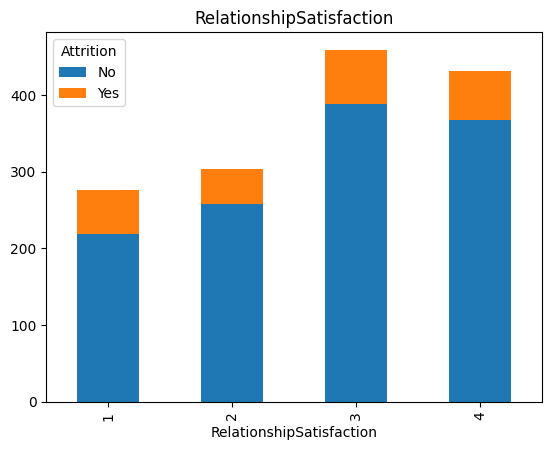

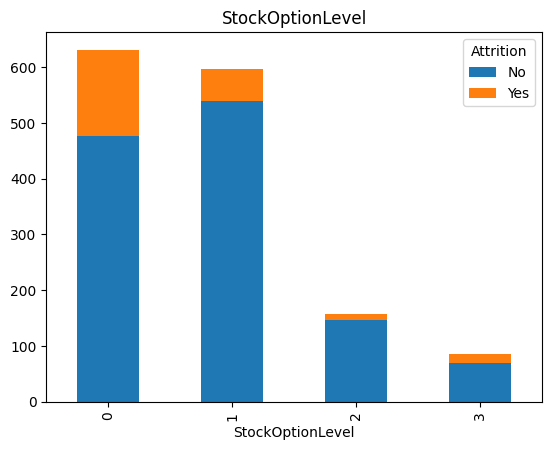

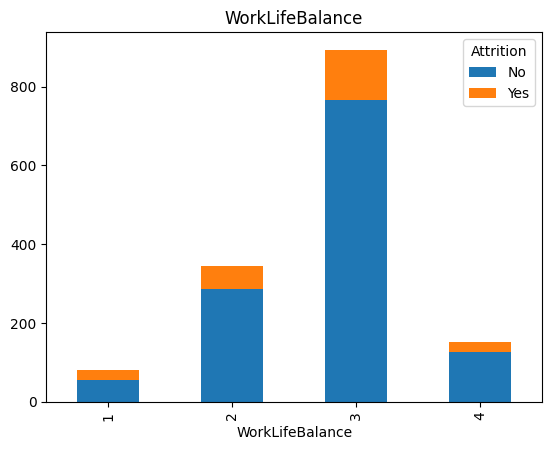

In [19]:
# categorical column과 dependent data(target column) 분포 분석
plt.figure(figsize=(30,30))
x = 1
#plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.8, wspace=0.2)
for column_name in list_categorical_columns:
    x = x+1
    df.groupby([column_name, "Attrition"]).count()["Age"].unstack().plot(kind='bar', stacked=True)
    plt.title(column_name)
plt.show()

Target Column(Attribution)이 애초에 불균형하기 때문에 위와 같이 나타내면 데이터 분포를 이해하기 어려움.

In [20]:
pd.crosstab(df[target_column], df["WorkLifeBalance"], normalize="index")

WorkLifeBalance,1,2,3,4
Attrition,,,,
No,0.044607,0.231955,0.621249,0.102190
Yes,0.105485,0.244726,0.535865,0.113924


In [21]:
pd.crosstab(df[target_column], df["WorkLifeBalance"], normalize="columns")

WorkLifeBalance,1,2,3,4
Attrition,,,,
No,0.6875,0.831395,0.857783,0.823529
Yes,0.3125,0.168605,0.142217,0.176471


In [22]:
pd.crosstab(df["WorkLifeBalance"], df[target_column], normalize="columns")

Attrition,No,Yes
WorkLifeBalance,,
1,0.044607,0.105485
2,0.231955,0.244726
3,0.621249,0.535865
4,0.102190,0.113924


<Figure size 3000x3000 with 0 Axes>

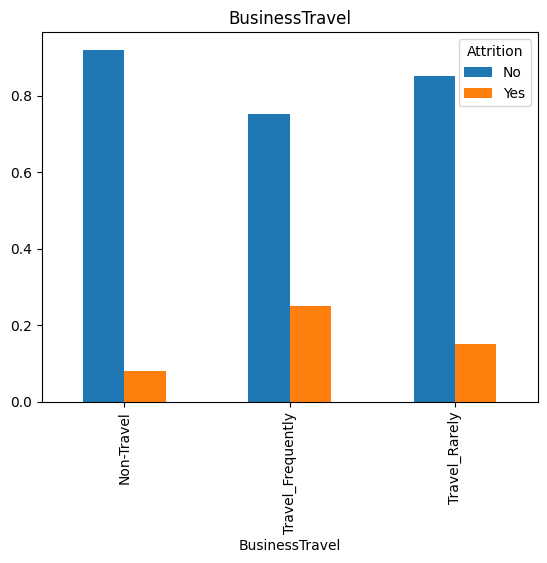

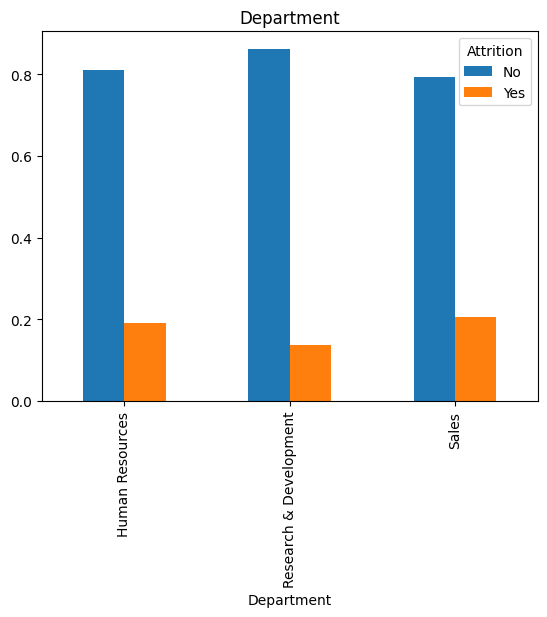

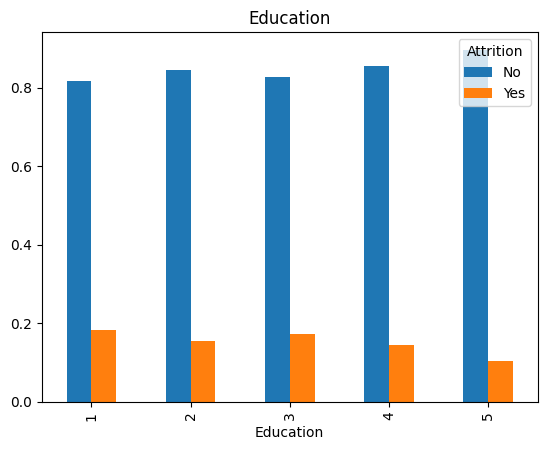

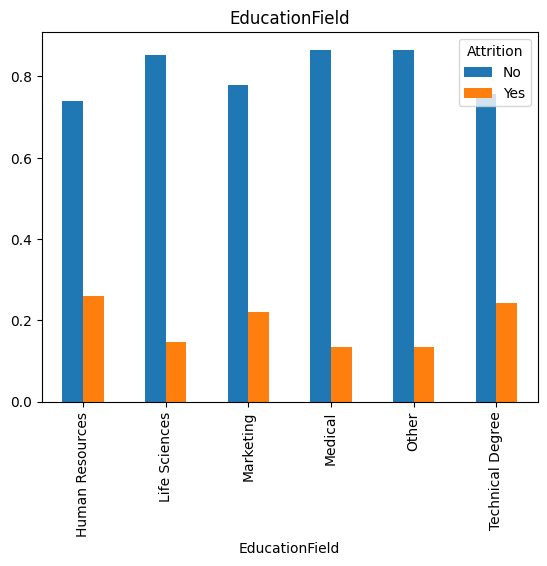

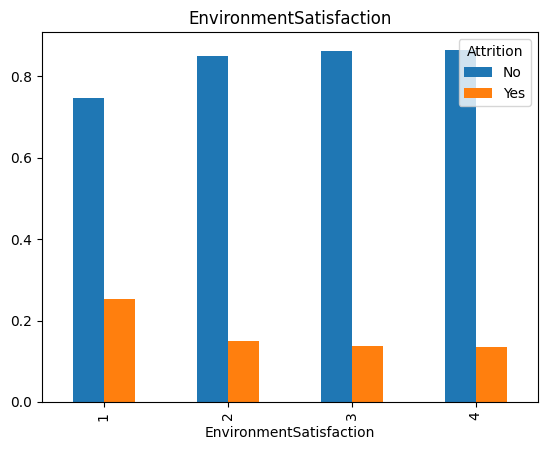

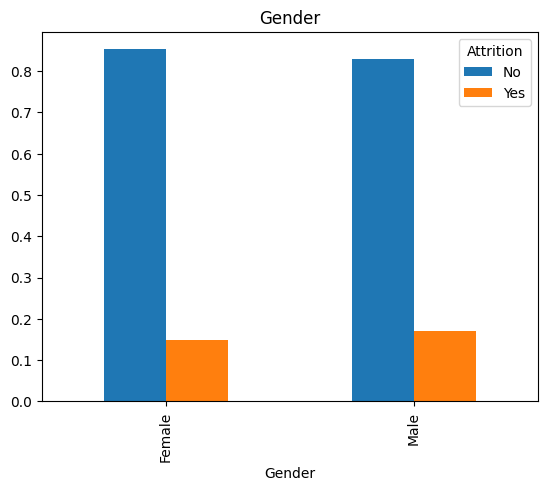

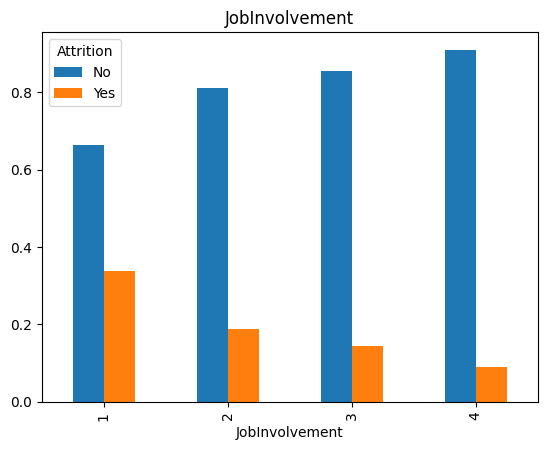

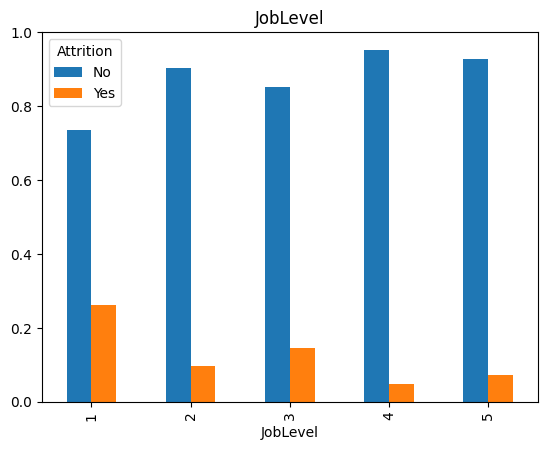

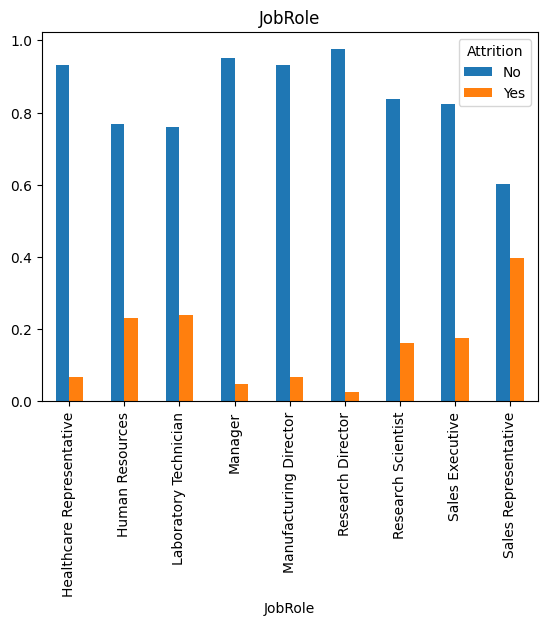

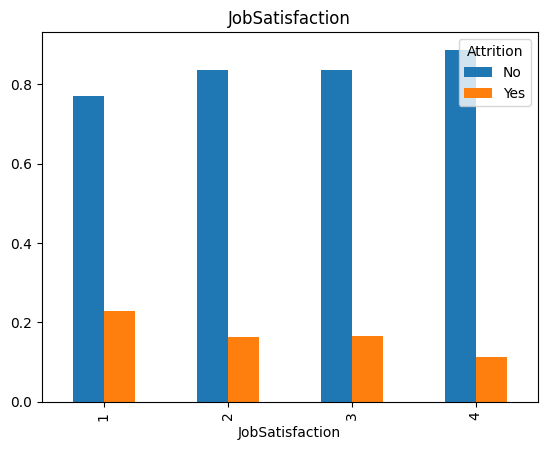

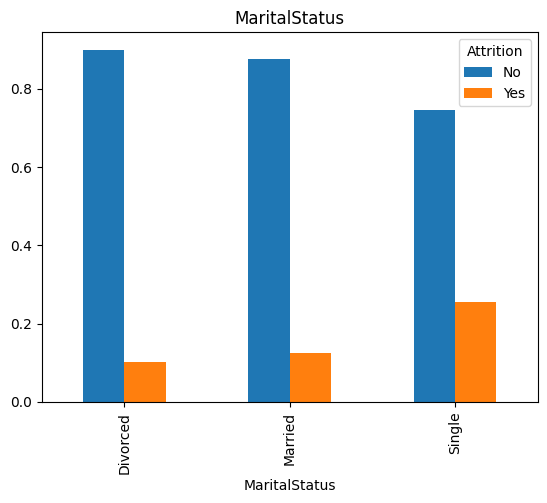

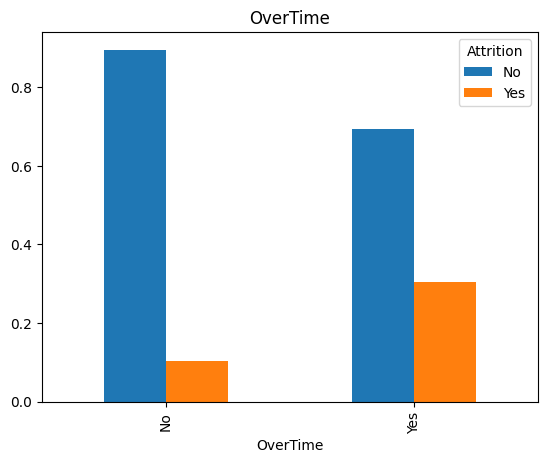

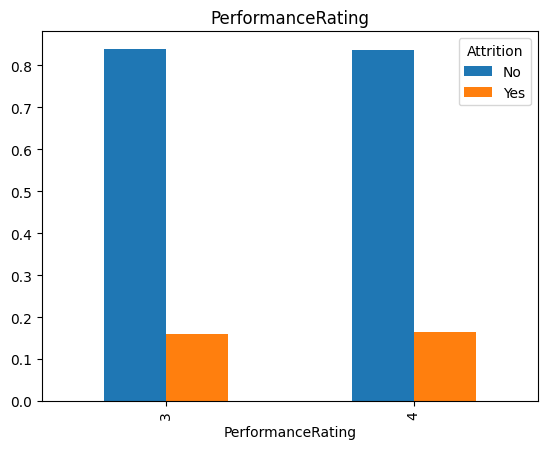

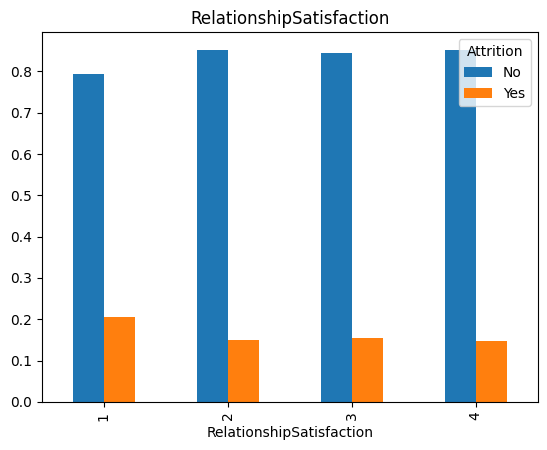

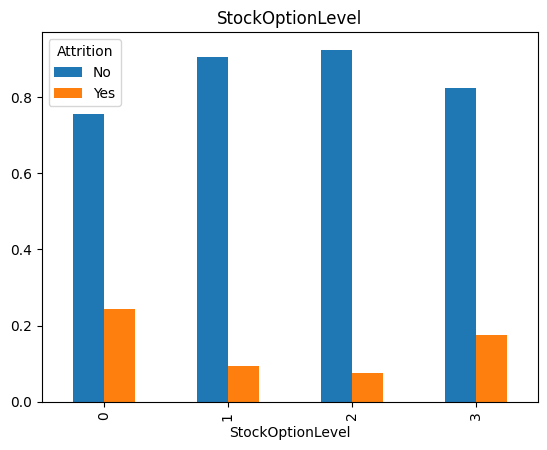

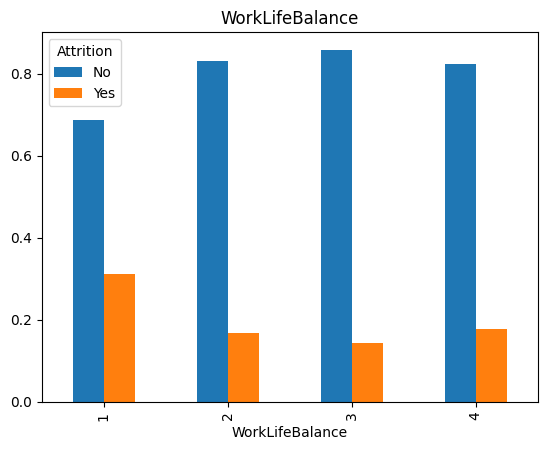

In [23]:
# categorical column과 dependent data(target column) 분포 분석
plt.figure(figsize=(30,30))
x = 1
#plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.8, wspace=0.2)
for column_name in list_categorical_columns:
    x = x+1
    #df.groupby([column_name, "Attrition"]).count()["Age"].unstack().plot(kind='bar', stacked=True)
    #pd.crosstab(df[target_column], df[column_name], normalize="index").plot.bar()
    pd.crosstab(df[column_name], df[target_column], normalize="index").plot.bar()
    plt.title(column_name)
plt.show()

#pd.crosstab(df[target_column], df[column_name], normalize="index").plot.bar()

##### 카이제곱 검정 (chisqaure-test)
*   카이제곱 검정은 두 범주형 변수에 대한 분석 방법.
*   예를 들어, 성별에 따른 선호 영화 장르 비교 문제.
*   카이제곱 검정은 3가지 종류가 있으며, 데이터 수집 방법과 가설에 따라 나뉜다. 본 실습에서는 독립성 검정(test of independence)를 진행한다.
*   본 실습에서는 독립 변수중의 categorical column data와 Attrition 간의 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/카이제곱_검정



##### 카이제곱 검정 추가 설명 : 3가지 유형
1.   적합도 검정 (Goodness of fit)
  - 변수 1개
  - 기존에 알려준 기준이 존재하는 검정
  - 예시) 상자 안에 공 3개가 같은 비율로 알려져 있음. 공 100개를 뽑았을 때, 각 색의 비율이 구해짐. -> 기존에 알려진 공 비율 분포를 따르는지 검정
  - 귀무가설 : 변수 X의 관측분포와 기대 분포가 동일
  - 대립가설 : 변수 X의 관측분포와 기대 분포가 동일하지 않음

2.   독립성 검정 (Test of independence)
  - 변수 2개
  - 범주형 두 변수가 서로 연관되어 있는지 여부를 검정
  - 예시) 성별과 흡연 여부 관계를 알고 싶어서 200명을 추출하여 조사한 경우.
  - 귀무가설 : 변수 X와 Y는 서로 독립
  - 대립가설 : 변수 X와 Y는 서로 독립이 아님
3.   동질성 검정 (Test of Homogeneity)
  - 변수 2개
  - 범주형 두 변수의 관계를 알기 위한 검정은 아님
  - 각 그룹들이 동질한지 알고 싶은 검정
  - 예시) 남자와 여자 흡연율 차이가 있는지 흡연율을 조사한 후, 두 그룹의 흡연율이 같은지 여부를 검정
  - 귀무가설 : 각 그룹의 확률분포가 동일
  - 대립가설 : 각 그룹의 확률분포가 동일하지 않음




In [16]:
list_meaningful_column_by_chi = []
for column_name in list_categorical_columns:
  statistic, pvalue, _, _ = chi2_contingency(pd.crosstab(df[target_column], df[column_name]))
  if pvalue <= 0.05:
    list_meaningful_column_by_chi.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all categorical columns : ", len(list_categorical_columns))
print("selected columns by chi : ", len(list_meaningful_column_by_chi), list_meaningful_column_by_chi)

BusinessTravel ,  24.182413685655174 ,  5.608614476449931e-06
Department ,  10.79600732241067 ,  0.004525606574479633
Education ,  3.0739613982367193 ,  0.5455253376565949
EducationField ,  16.024674119585423 ,  0.006773980139025222
EnvironmentSatisfaction ,  22.503881435842295 ,  5.1234689062894205e-05
Gender ,  1.1169671241970975 ,  0.29057244902890855
JobInvolvement ,  28.492021234659283 ,  2.8631806367134195e-06
JobLevel ,  72.52901310667391 ,  6.634684715458909e-15
JobRole ,  86.19025367670434 ,  2.752481638050657e-15
JobSatisfaction ,  17.505077010348 ,  0.0005563004510387556
MaritalStatus ,  46.163676540848705 ,  9.45551106034083e-11
OverTime ,  87.56429365828768 ,  8.15842372153832e-21
PerformanceRating ,  0.00015475439428271534 ,  0.9900745465934576
RelationshipSatisfaction ,  5.241067859713708 ,  0.15497244371052626
StockOptionLevel ,  60.59830108612225 ,  4.379390336108354e-13
WorkLifeBalance ,  16.3250970916474 ,  0.0009725698845348824
all categorical columns :  16
selected

##### Insight
1.   Attrition(종속 변수)와 유의미한 관계를 갖지 않는 categorical data가 확인됨
2.   feature selection 및 model optimization을 위해 1번에서 얻은 결과를 활용



#### 2) Numeric Data Analysis

##### 불필요한 컬럼 제거

In [17]:
df[list_numeric_columns].nunique().sort_values()

EmployeeCount                 1
StandardHours                 1
TrainingTimesLastYear         7
NumCompaniesWorked           10
PercentSalaryHike            15
YearsSinceLastPromotion      16
YearsWithCurrManager         18
YearsInCurrentRole           19
DistanceFromHome             29
YearsAtCompany               37
TotalWorkingYears            40
Age                          43
HourlyRate                   71
DailyRate                   886
MonthlyIncome              1349
MonthlyRate                1427
dtype: int64

In [18]:
df["MonthlyRate"]

0       19479
1       24907
2        2396
3       23159
4       16632
        ...  
1465    12290
1466    21457
1467     5174
1468    13243
1469    10228
Name: MonthlyRate, Length: 1470, dtype: int64

In [19]:
# 불필요한 컬럼을 제거
# unique number가 1인 것들 제거
df = df.drop(["EmployeeCount", "StandardHours"], axis=1).copy()
list_numeric_columns.remove("EmployeeCount")
list_numeric_columns.remove("StandardHours")
print(list_numeric_columns)

['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


##### Column별 분포 확인

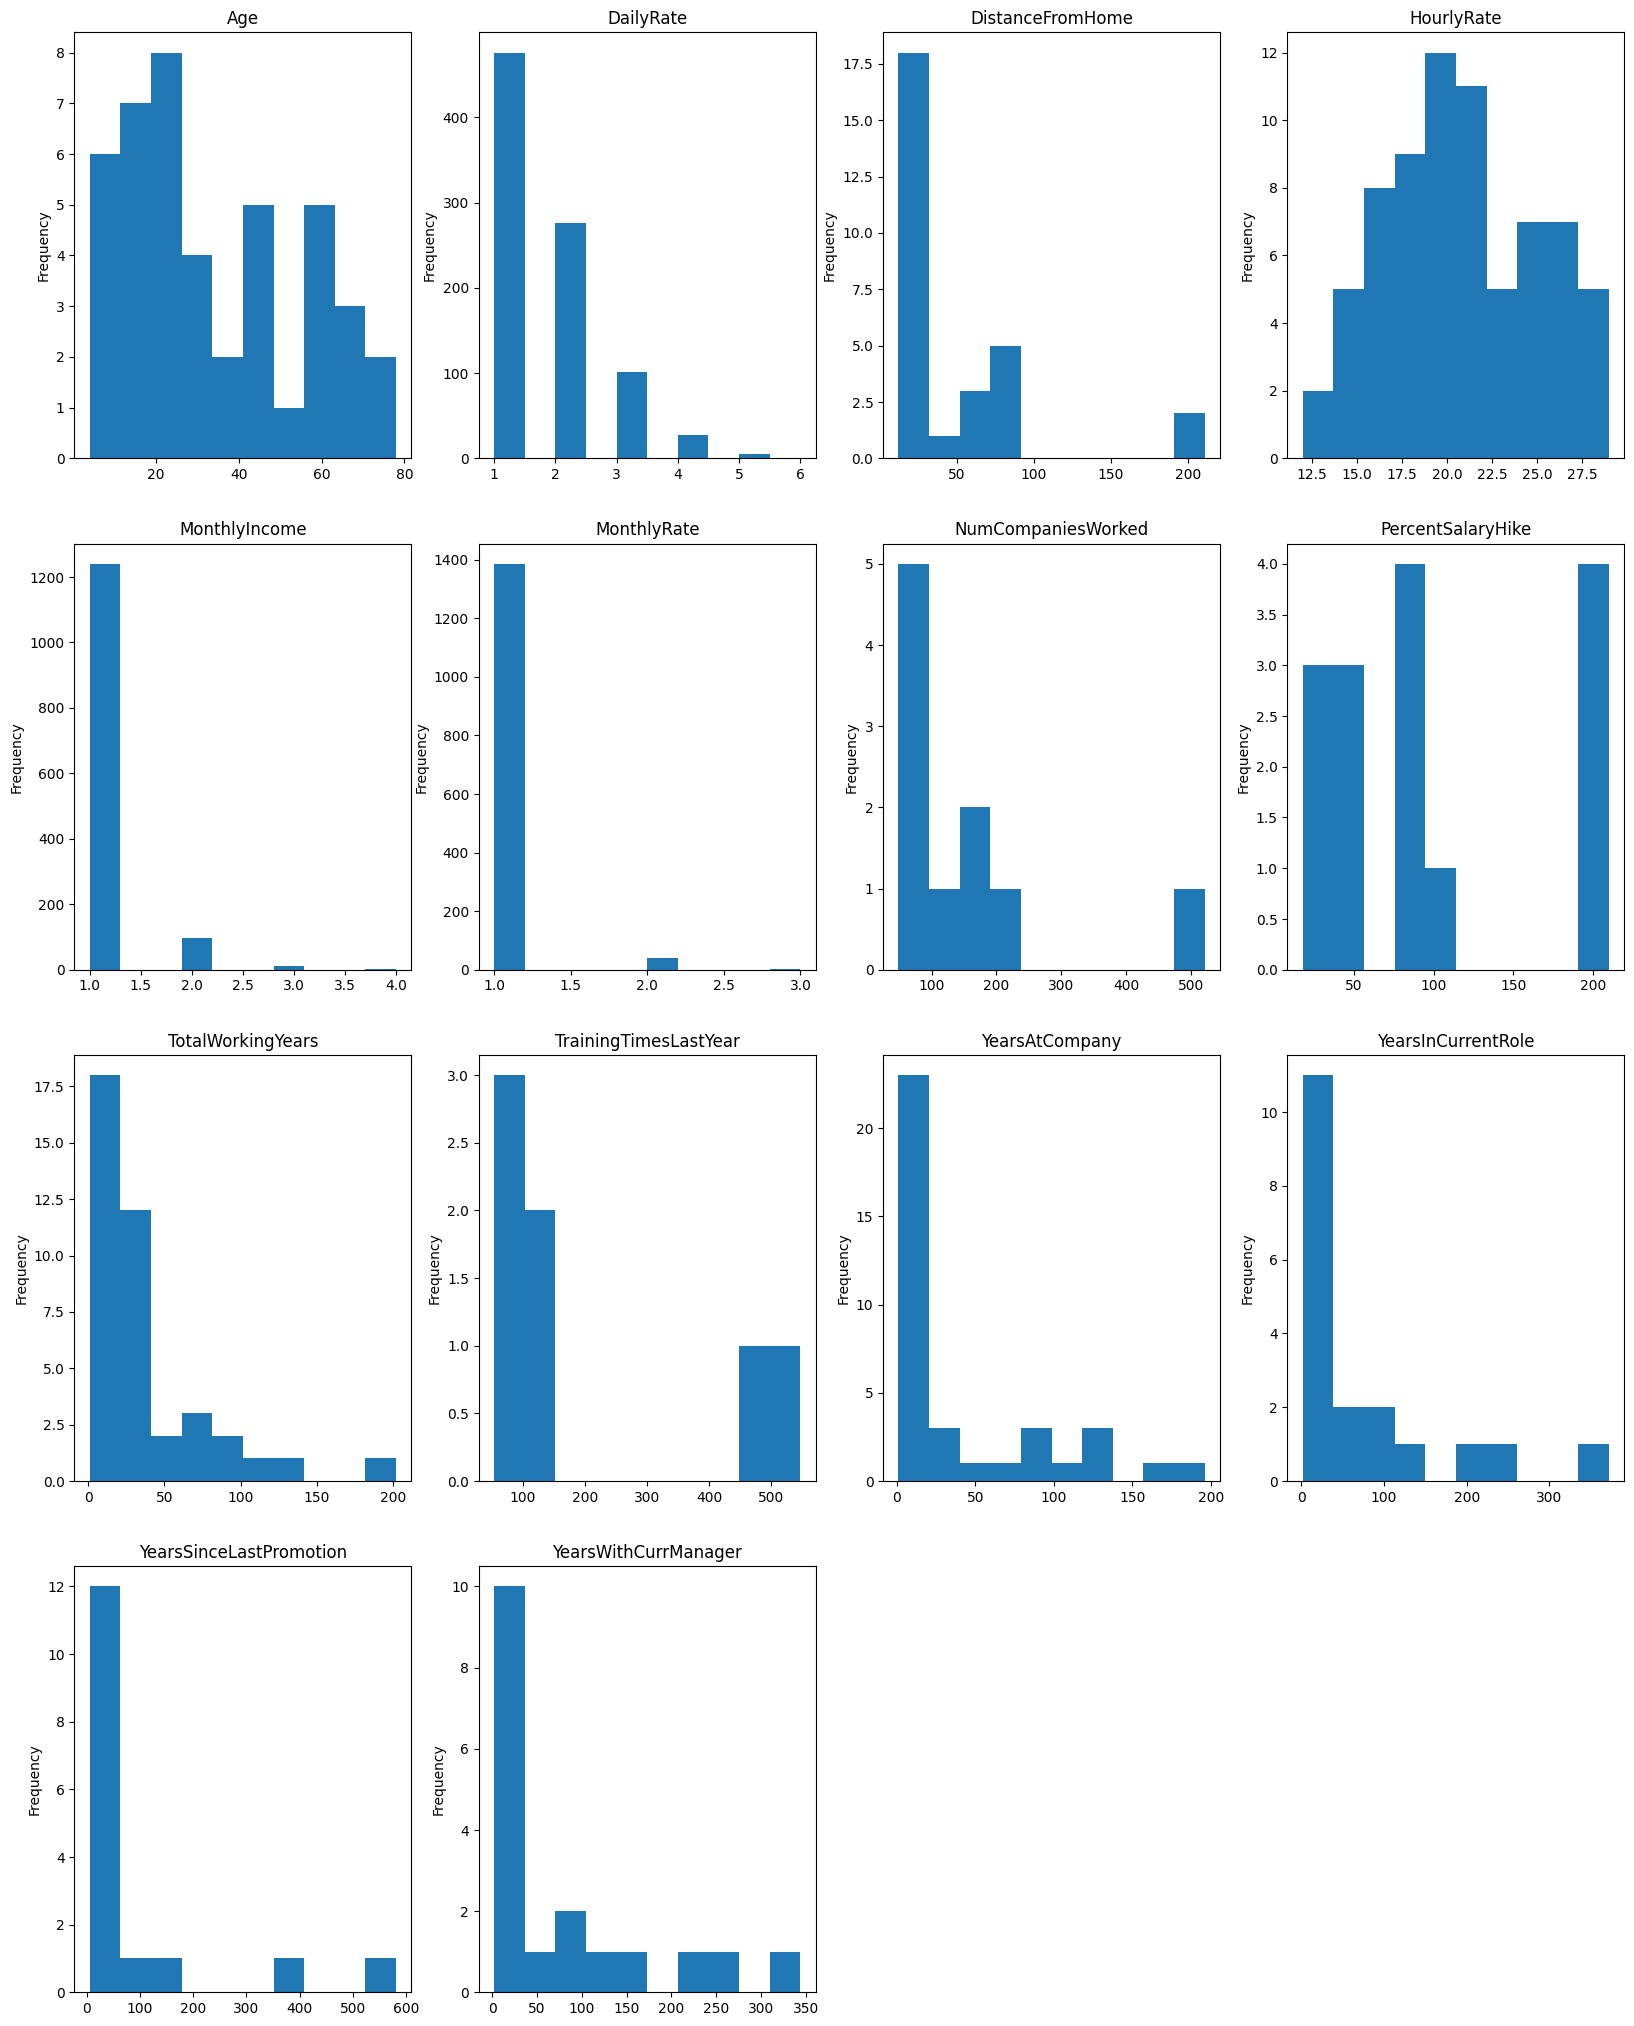

In [28]:
# numeric column 별 분포 확인
plt.figure(figsize=(20,20))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(4,4,x)
    x = x+1
    df[column_name].value_counts().plot(kind='hist')
    plt.title(column_name)
plt.show()

<Axes: xlabel='MonthlyIncome', ylabel='Age'>

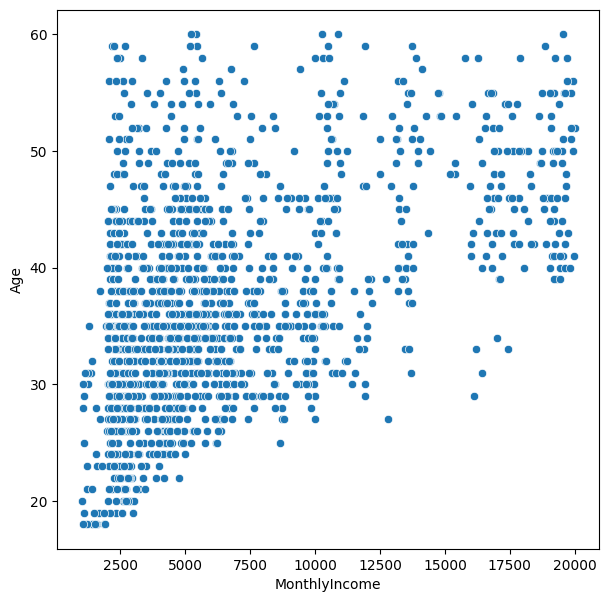

In [29]:
# scatter plot 1
plt.figure(figsize=(7,7))
sns.scatterplot(data=df, x="MonthlyIncome", y="Age")

<Axes: xlabel='TotalWorkingYears', ylabel='MonthlyIncome'>

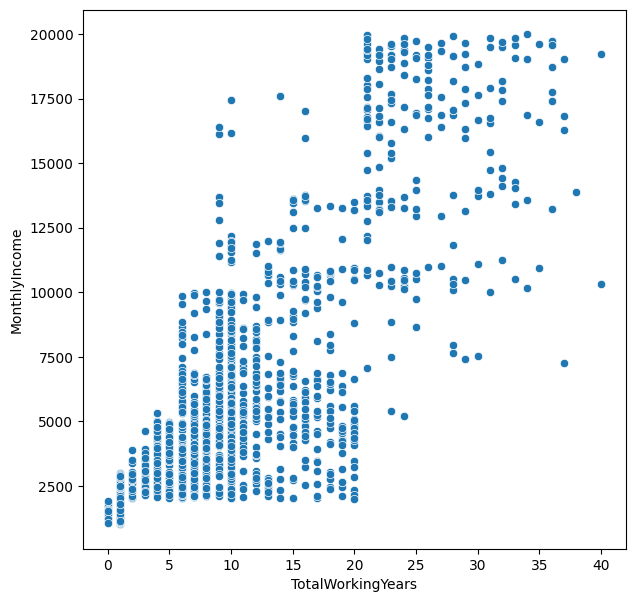

In [30]:
# scatter plot 2
plt.figure(figsize=(7,7))
sns.scatterplot(data=df, x="TotalWorkingYears", y="MonthlyIncome")

<Axes: xlabel='PerformanceRating', ylabel='PercentSalaryHike'>

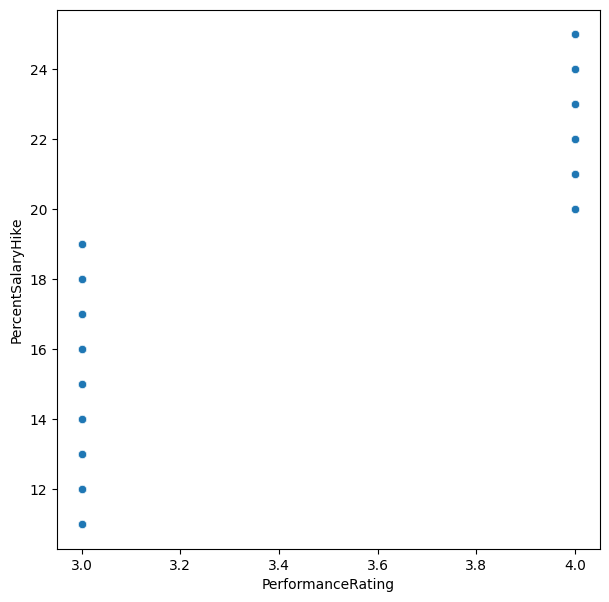

In [31]:
# scatter plot 3
plt.figure(figsize=(7,7))
sns.scatterplot(data=df, x="PerformanceRating", y="PercentSalaryHike")

In [32]:
sns.pairplot(df[list_numeric_columns])

Output hidden; open in https://colab.research.google.com to view.

##### Correlation Analysis

<Axes: >

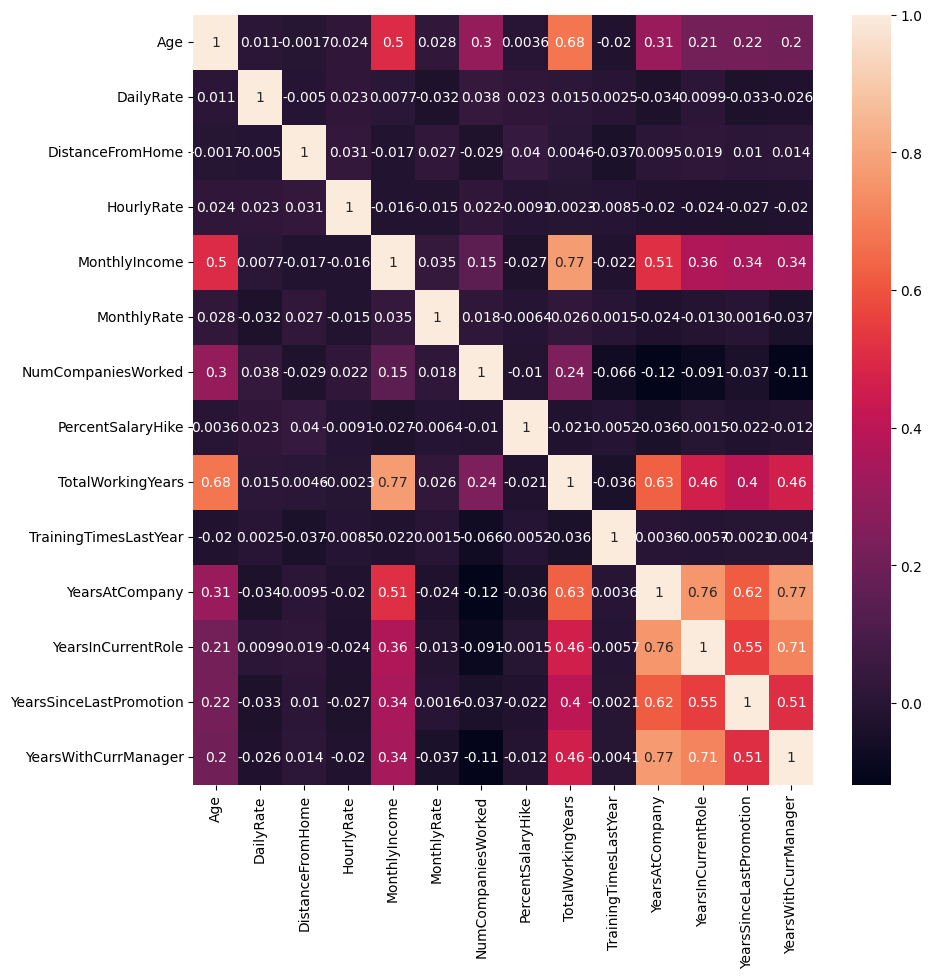

In [20]:
df_corr = df[list_numeric_columns].corr()
plt.figure(figsize=(10,10))
sns.heatmap(df_corr, annot=True)

##### VIF Analysis
-   일반적으로는는 10이상인인 경우 다중공선성이이 있다고 가정
-   high correlation 컬럼을 제거하기 전에 한 번 더 검정을 진행 (doublecheck, 개인의 판단에 따라서 진행하지 않아도됨)

In [21]:
def caculate_vif(df_target):
  vif = pd.DataFrame()
  vif['VIF_Factor'] = [variance_inflation_factor(df_target.values, i) for i in range(df_target.shape[1])]
  vif['Feature'] = df_target.columns
  return vif

df_vif = df[list_numeric_columns].copy()

In [22]:
caculate_vif(df_vif)

,VIF_Factor,Feature
0,25.496860,Age
1,4.721572,DailyRate
2,2.271398,DistanceFromHome
3,9.767720,HourlyRate
4,7.286833,MonthlyIncome
5,4.737393,MonthlyRate
6,2.675998,NumCompaniesWorked
7,13.578688,PercentSalaryHike
8,13.311109,TotalWorkingYears
9,5.302141,TrainingTimesLastYear


In [23]:
caculate_vif(df_vif.drop(["TotalWorkingYears","Age","PercentSalaryHike"],axis=1))

,VIF_Factor,Feature
0,4.365355,DailyRate
1,2.205211,DistanceFromHome
2,7.507071,HourlyRate
3,4.212697,MonthlyIncome
4,4.343285,MonthlyRate
5,2.263575,NumCompaniesWorked
6,4.710238,TrainingTimesLastYear
7,9.432830,YearsAtCompany
8,6.322306,YearsInCurrentRole
9,2.435655,YearsSinceLastPromotion


In [24]:
list_numeric_feature_by_vif = list_numeric_columns.copy()
list_numeric_feature_by_vif.remove("TotalWorkingYears")
list_numeric_feature_by_vif.remove("Age")
list_numeric_feature_by_vif.remove("PercentSalaryHike")

list_numeric_feature_by_vif

['DailyRate',
 'DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

##### Target Column과 numeric Column 관계 분포 확인

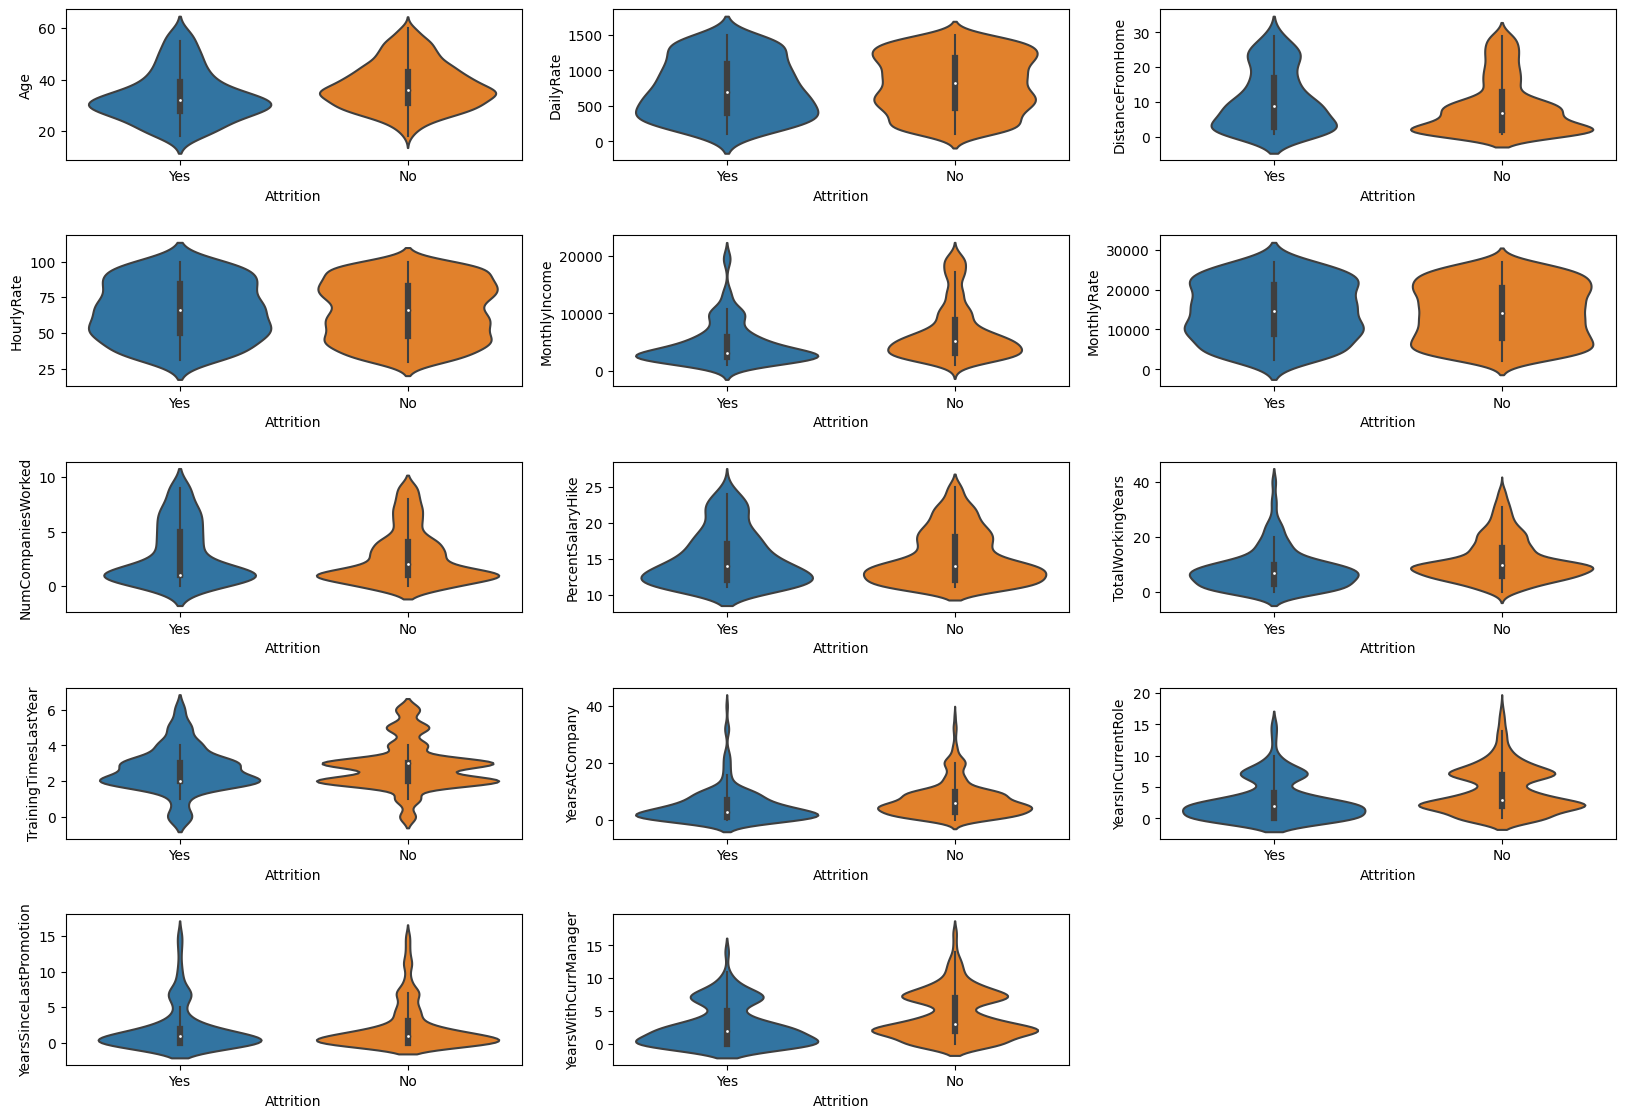

In [38]:
plt.figure(figsize=(20,20))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(9,3,x)
    x = x + 1
    sns.violinplot(data=df,x=target_column,y=column_name)
plt.show()

##### 일원분산분석 (ANOVA)
*   카테고리별 numeric data 분포 차이를 검증
*   전제 : 정규성, 등분산성, 독립성 (만족하지 않으면 해당 검정을 신뢰할 수 없음)
*   본 실습에서는 Attrition 에 따른 numeric column data 분포 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/분산_분석#일원분산분석(one-way_ANOVA)





정규성 검정
*   귀무가설 : 모집단의 분포는 정규 분포이다
*   검정 방법 : Shpiro-Wilks Test, qqplot
*   p-value < 0.05이면, 귀무가설 기각 (기각하지 못하여야 정규성을 만족)

In [25]:
# shapiro wilk test 검정
# 귀무가설 : 해당 데이터는 정규분포이다.
# pvalue <0.05 이면 귀무가설 기각
for column_name in list_numeric_columns:
  statistic, pvalue = stats.shapiro(df[column_name])
  if pvalue >= 0.05:
    print(column_name)
print("end")

end


Box-Cox Transformation
*   Box 와 Cox는 적절한 비선형 변환으로 정규성을 만족시킬 수 있다고 주장
*   람다 값에 따라서 변수 변환이 결정되는 방식
*   장점 : 반응 변수의 정규성을 만족시킬 수 있음
*   단점 : 해석이 어려움
*   https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation


In [26]:
# boxcox transformation
for column_name in list_numeric_columns:
  condition = (df[column_name] > 0)
  statistic, pvalue = stats.shapiro(stats.boxcox(df.loc[condition, column_name])[0])
  if pvalue >= 0.05:
    print(column_name)
print("end")

end


In [27]:
# log transfomration
for column_name in list_numeric_columns:
  condition = (df[column_name] > 0)
  statistic, pvalue = stats.shapiro(np.log(df.loc[condition, column_name]))
  if pvalue >= 0.05:
    print(column_name)
print("end")

end


##### 크루스칼 왈리스 검정 Kruskall-Wallis test (비모수 검정)
*   비모수 검정이기 때문에 정규성/등분산성을 만족하지 않아도됨
*   단, 비모수 검정이기 때문에 검정 결과 신뢰도가 모수 검정보다 떨어짐

In [28]:
# kruskall 검정
list_meaningful_column_by_kruskall = []

for column_name in list_numeric_columns:
  list_by_value = []
  for value in df[target_column].dropna().unique():
      df_tmp = df[df[target_column] == value][column_name].dropna()
      list_by_value.append(np.array(df_tmp))
  statistic, pvalue = kruskal(*list_by_value)
  if pvalue <= 0.05:
    list_meaningful_column_by_kruskall.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all categorical columns : ", len(list_numeric_columns))
print("selected columns by kruskal : ", len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall)

Age ,  43.06268844023747 ,  5.3013684961038114e-11
DailyRate ,  4.767706640276287 ,  0.02899842966260463
DistanceFromHome ,  9.225723965000004 ,  0.002386383151703113
HourlyRate ,  0.06579158284658387 ,  0.7975657845068993
MonthlyIncome ,  57.768241263784475 ,  2.948926498830519e-14
MonthlyRate ,  0.3419741493810883 ,  0.5586919160154533
NumCompaniesWorked ,  1.3669853624354948 ,  0.24233051615850376
PercentSalaryHike ,  0.8190089297863566 ,  0.3654700908743005
TotalWorkingYears ,  58.175049815828345 ,  2.3980118249072023e-14
TrainingTimesLastYear ,  3.9351850554126635 ,  0.04728593768607503
YearsAtCompany ,  53.26510705772158 ,  2.9143753542698205e-13
YearsInCurrentRole ,  47.925653386167035 ,  4.426912787258302e-12
YearsSinceLastPromotion ,  4.168984320865666 ,  0.04117047318275827
YearsWithCurrManager ,  45.17087528790509 ,  1.8057061514626796e-11
all categorical columns :  14
selected columns by kruskal :  10 ['Age', 'DailyRate', 'DistanceFromHome', 'MonthlyIncome', 'TotalWorkingYe

In [29]:
# kruskall 검정과 vif 분석에서 Target Column과 유의미한 관계를 갖는 것들의 교집합
list_meaningful_vif_and_kruskall = list(np.intersect1d(list_numeric_feature_by_vif,list_meaningful_column_by_kruskall))
print(len(list_meaningful_vif_and_kruskall))

8


In [30]:
list_meaningful_vif_and_kruskall

['DailyRate',
 'DistanceFromHome',
 'MonthlyIncome',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

##### Insight
1.   Attrition(종속 변수)와 유의미한 관계를 갖지 않는 numerical data가 확인됨
2.   feature selection 및 model optimization을 위해 1번에서 얻은 결과를 활용
3.   numercial data 간의 다중공선성이 의심되는 변수들이 있음
4.   kruskall 검정과 vif 분석에서 문제가 없는 numerial data는 총 8개



## 3. Data Processing 2

### 3-1 Missing Values

In [31]:
df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

### 3-2 Feature Transformation

In [32]:
Y = df[target_column]
X = df.drop([target_column], axis=1)

In [33]:
Y

0       Yes
1        No
2       Yes
3        No
4        No
       ... 
1465     No
1466     No
1467     No
1468     No
1469     No
Name: Attrition, Length: 1470, dtype: object

##### Label Encoding

In [34]:
le_encoder = LabelEncoder()
Y_encoded = le_encoder.fit_transform(Y)
Y_encoded

array([1, 0, 1, ..., 0, 0, 0])

##### Feature Selection

In [35]:
X_fs = df[list_meaningful_column_by_chi + list_meaningful_vif_and_kruskall]
X_fs

,BusinessTravel,Department,EducationField,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,OverTime,StockOptionLevel,WorkLifeBalance,DailyRate,DistanceFromHome,MonthlyIncome,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,Travel_Rarely,Sales,Life Sciences,2,3,2,Sales Executive,4,Single,Yes,0,1,1102,1,5993,0,6,4,0,5
1,Travel_Frequently,Research & Development,Life Sciences,3,2,2,Research Scientist,2,Married,No,1,3,279,8,5130,3,10,7,1,7
2,Travel_Rarely,Research & Development,Other,4,2,1,Laboratory Technician,3,Single,Yes,0,3,1373,2,2090,3,0,0,0,0
3,Travel_Frequently,Research & Development,Life Sciences,4,3,1,Research Scientist,3,Married,Yes,0,3,1392,3,2909,3,8,7,3,0
4,Travel_Rarely,Research & Development,Medical,1,3,1,Laboratory Technician,2,Married,No,1,3,591,2,3468,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,Travel_Frequently,Research & Development,Medical,3,4,2,Laboratory Technician,4,Married,No,1,3,884,23,2571,3,5,2,0,3
1466,Travel_Rarely,Research & Development,Medical,4,2,3,Healthcare Representative,1,Married,No,1,3,613,6,9991,5,7,7,1,7
1467,Travel_Rarely,Research & Development,Life Sciences,2,4,2,Manufacturing Director,2,Married,Yes,1,3,155,4,6142,0,6,2,0,3
1468,Travel_Frequently,Sales,Medical,4,2,2,Sales Executive,2,Married,No,0,2,1023,2,5390,3,9,6,0,8


##### One-hot Encoding for categorical column data

In [36]:
X_base = pd.get_dummies(X)
X_fs_final = pd.get_dummies(X_fs)

<ipython-input-36-a6b2f43527bd>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X_base = pd.get_dummies(X)
<ipython-input-36-a6b2f43527bd>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X_base = pd.get_dummies(X)
<ipython-input-36-a6b2f43527bd>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X_base = pd.get_dummies(X)
<ipython-input-36-a6b2f43527bd>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X_base = pd.get_dummies(X)
<ipython-input-36-a6b2f43527bd>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dt

In [37]:
X_fs_final

,DailyRate,DistanceFromHome,MonthlyIncome,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,...,OverTime_No,OverTime_Yes,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,WorkLifeBalance_1,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4
0,1102,1,5993,0,6,4,0,5,0,0,...,0,1,1,0,0,0,1,0,0,0
1,279,8,5130,3,10,7,1,7,0,1,...,1,0,0,1,0,0,0,0,1,0
2,1373,2,2090,3,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
3,1392,3,2909,3,8,7,3,0,0,1,...,0,1,1,0,0,0,0,0,1,0
4,591,2,3468,3,2,2,2,2,0,0,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,884,23,2571,3,5,2,0,3,0,1,...,1,0,0,1,0,0,0,0,1,0
1466,613,6,9991,5,7,7,1,7,0,0,...,1,0,0,1,0,0,0,0,1,0
1467,155,4,6142,0,6,2,0,3,0,0,...,0,1,0,1,0,0,0,0,1,0
1468,1023,2,5390,3,9,6,0,8,0,1,...,1,0,1,0,0,0,0,1,0,0


##### Sampling for imbalanced data (combined samping)
*   SMOTEENN : SMOTE + ENN
*   https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html


In [38]:
X_fs_final_train, X_fs_final_validation, y_fs_final_train, y_fs_final_validation = train_test_split(X_fs_final, Y_encoded, stratify=Y_encoded)

In [39]:
sme = SMOTEENN(random_state=random_state)
X_fs_sme_sampling, y_sme_sampling = sme.fit_resample(X_fs_final_train, y_fs_final_train)

Text(0.5, 1.0, 'After sampling for target label')

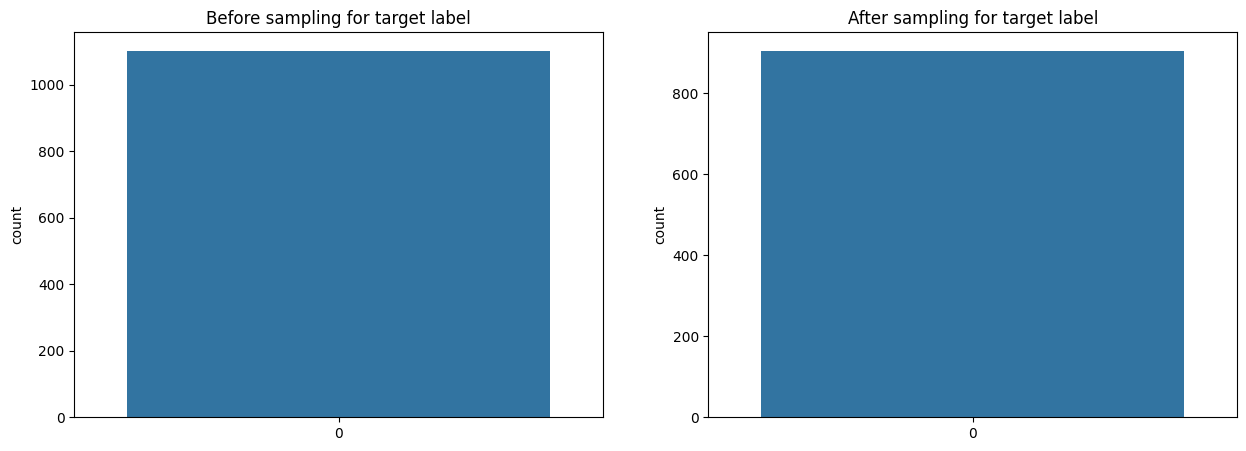

In [40]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
sns.countplot(y_fs_final_train)
plt.title("Before sampling for target label")

fig.add_subplot(122)
sns.countplot(y_sme_sampling)
plt.title("After sampling for target label")

### 3-3 Summary
##### 총 3개 유형의 feature를 생성 -> model optimization 실험
1.   No Feature Selection + No sampling (X_base, Y_encoded)
2.   Feature Selection (X_fs_final, Y_encoded)
3.   Feature Selection + Combined Sampling (X_fs_sme_sampling, y_sme_sampling / X_fs_final_validation, y_fs_final_validation)

  

## 4. Model Analysis
1.   base model (No Feature Selection + No sampling)
2.   ML with Feature Selection (No samping)
3.   ML with Feature selection and Combined Sampling
4.   ML with Feature Selection and No Combined Sampilng + Cost Sensitive Learning


In [56]:
list_model_metric = []
cv = 3
n_jobs = -1

### 4-1. Base Model Learning

In [57]:
X_train, X_validation, y_train, y_validation = train_test_split(X_base, Y_encoded, test_size = 0.3, random_state = random_state)

In [58]:
xgb_clf = XGBClassifier(max_depth = 4, n_estimators=5)
xgb_clf.fit(X_train, y_train)
y_prd = xgb_clf.predict_proba(X_validation)[:,-1]
score = roc_auc_score(y_validation, y_prd)
print("roc_auc_score : ", score)
list_model_metric.append(score)

roc_auc_score :  0.762148633038121


### 4-2. Optimization 1 :  ML with Feature Selection (No samping)

In [59]:
X_train, X_validation, y_train, y_validation = train_test_split(X_fs_final, Y_encoded, test_size = 0.3, random_state = random_state)

In [60]:
hyper_params_xgb = {"colsample_bytree":[0.8, 1.0],
                    "min_child_weight":[1.0,1.2],
                    'max_depth': [4, 6, 8, 10],
                    'n_estimators': [10, 15, 20, 25]}

xgb_clf = XGBClassifier(max_depth = 4, n_estimators=5)
grid_cv_opt1 = GridSearchCV(xgb_clf, param_grid = hyper_params_xgb, cv = cv, n_jobs = n_jobs)
grid_cv_opt1.fit(X_train, y_train)
print('best model hyper-parameter : ', grid_cv_opt1.best_params_)
y_prd = grid_cv_opt1.predict_proba(X_validation)[:,-1]
score = roc_auc_score(y_validation, y_prd)
print("roc_auc_score : ", score)
list_model_metric.append(score)

best model hyper-parameter :  {'colsample_bytree': 1.0, 'max_depth': 6, 'min_child_weight': 1.2, 'n_estimators': 15}
roc_auc_score :  0.8051597997689642


### 4-3. Optimization 2 : ML with Feature selection and Combined Sampling

In [61]:
# X_fs_sme_sampling, y_sme_sampling / X_fs_final_validation, y_fs_final_validation

In [62]:
hyper_params_xgb = {"colsample_bytree":[0.8, 1.0],
                    "min_child_weight":[1.0,1.2],
                    'max_depth': [4, 6, 8, 10],
                    'n_estimators': [10, 15, 20, 25]}

xgb_clf = XGBClassifier(max_depth = 4, n_estimators=5)
grid_cv_opt2 = GridSearchCV(xgb_clf, param_grid = hyper_params_xgb, cv = cv, n_jobs = n_jobs)
grid_cv_opt2.fit(X_fs_sme_sampling, y_sme_sampling)
print('best model hyper-parameter : ', grid_cv_opt2.best_params_)
y_prd = grid_cv_opt2.predict_proba(X_fs_final_validation)[:,-1]
score = roc_auc_score(y_fs_final_validation, y_prd)
print("roc_auc_score : ", score)
list_model_metric.append(score)

best model hyper-parameter :  {'colsample_bytree': 1.0, 'max_depth': 6, 'min_child_weight': 1.2, 'n_estimators': 10}
roc_auc_score :  0.7659481103614723


### 4-4. Optimization 3 : ML with Feature Selection and No Combined Sampilng + Cost Sensitive Learning

In [63]:
#from sklearn.utils import class_weight
#classes_weights = class_weight.compute_sample_weight(
##    class_weight='balanced',
#  y=train_df['class']
#)

#xgb_classifier.fit(X, y, sample_weight=classes_weights)

In [64]:
X_train, X_validation, y_train, y_validation = train_test_split(X_fs_final, Y_encoded, test_size = 0.3, random_state = random_state)

In [ ]:
hyper_params_xgb = {"colsample_bytree":[0.8, 1.0],
                    "min_child_weight":[1.0,1.2],
                    'max_depth': [4, 6, 8, 10],
                    'n_estimators': [10, 15, 20, 25],
                    'sample_weight':compute_sample_weight("balanced", y_train)}

xgb_clf = XGBClassifier(max_depth = 4, n_estimators=5)
grid_cv_opt3 = GridSearchCV(xgb_clf, param_grid = hyper_params_xgb, cv = cv, n_jobs = n_jobs)
grid_cv_opt3.fit(X_train, y_train)
print('best model hyper-parameter : ', grid_cv_opt3.best_params_)
y_prd = grid_cv_opt3.predict_proba(X_validation)[:,-1]
score = roc_auc_score(y_validation, y_prd)
print("roc_auc_score : ", score)
list_model_metric.append(score)

In [ ]:
df_metric = pd.DataFrame({'Model':['basic', 'featue selection', 'feature selection and combinedsampling', 'feature selection and cost-sensitive learning'], 'roc_auc_score':list_model_metric})
ax = df_metric.plot.barh(x='Model', y='roc_auc_score', rot=0, figsize=(10,5), legend=False)
for bar in ax.patches:
    ax.annotate(format(bar.get_width(), '.4f'),
                   (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                   size=15, xytext=(8, 0),
                   textcoords='offset points')

# cost-sensitive learning이 의미가 없음
# 이미 불균형중 minority 데이터 분포가 확실함